In [57]:
import torch
import pandas as pd
from dataset import XrayDataset
from multimodel import Multimodel
from transform import val_transform
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_path= '/home/jupyter-nafisha/normal-abnormal-multitask/main/last_model.pth'

In [59]:
# img_dir = '/home/common/data_v3'
img_dir = '/home/jupyter-nafisha/X-ray-covariates/data_v3_testing'
test_csv = '/home/jupyter-nafisha/normal-abnormal-multitask/CSVs/test_withoutBbox.csv'

# padchest
# img_dir = '/home/jupyter-nafisha/X-ray-covariates/padchest_normalized'
# test_csv = '/home/jupyter-nafisha/normal-abnormal-multitask/CSVs/padchest_withoutBbox.csv'

In [60]:
model = Multimodel().to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

/home/jupyter-nafisha/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-nafisha/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Multimodel(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum

In [61]:
test_dataset = XrayDataset(img_dir, test_csv, transform_nobbox=val_transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4
)

In [62]:
true_labels = test_dataset.df["label"].map({"Normal": 0, "Abnormal": 1}).tolist()
image_names = test_dataset.df["image_id"].tolist()

In [63]:
# predictions = []
# true_labels = []
# probabilities = []
# image_names = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.63

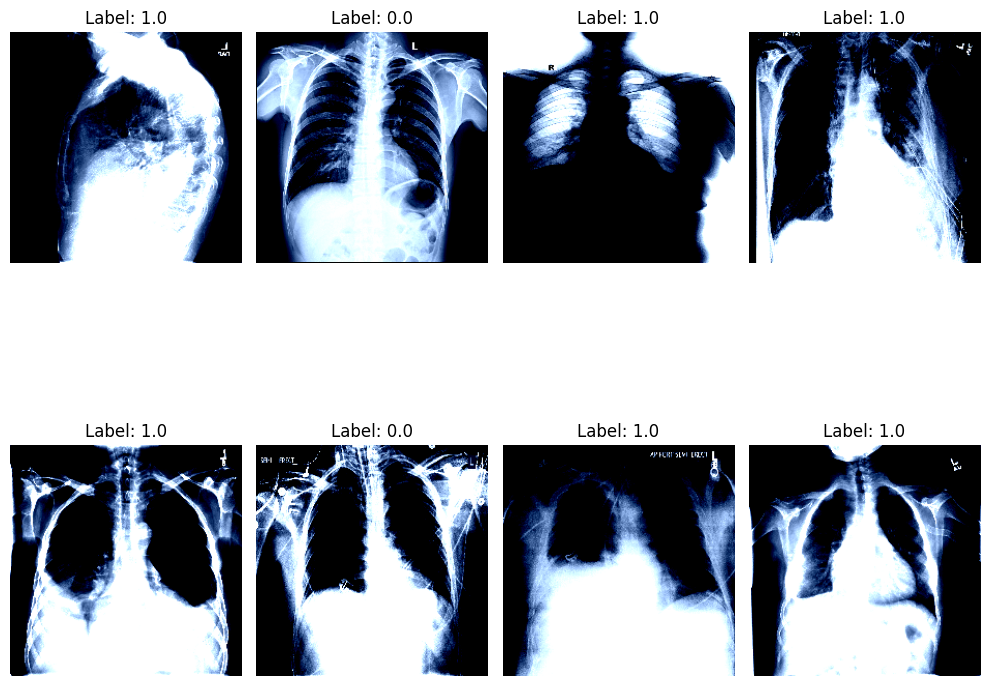

In [64]:
import matplotlib.pyplot as plt
import torch

for images, _, label, _, _l in test_loader:
    break  

# Plot 16 images in a 4x4 grid
fig, axes = plt.subplots(2, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(8):
    img = images[i].permute(1, 2, 0)  # C,H,W → H,W,C
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label: {label[i].item()}")

plt.tight_layout()
plt.show()

In [65]:
# with torch.no_grad():
#     for images, _, labels, _, _ in test_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         outputs = model(images)
#         preds = (torch.sigmoid(outputs) > 0.5).int()

#         predictions.extend(preds.cpu().tolist())
#         true_labels.extend(labels.int().tolist())

predictions = []
true_labels = []
probabilities = []

with torch.no_grad():
    for images, _, labels, _, _ in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)                 # logits
        probs = torch.sigmoid(outputs).squeeze()  # probabilities

        preds = (probs > 0.5).int()

        probabilities.extend(probs.cpu().numpy())
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


In [66]:
df = pd.DataFrame({
    "image_name": image_names,
    "true_label": true_labels,
    "predicted_label": predictions
})

In [45]:
df[df['predicted_label']==1]

,image_name,true_label,predicted_label
0,chexpert/patient20327/study1/view2_lateral.jpg,1,1
2,vinbig/5f4eff3b76151906fe87be784d191a1f.jpg,1,1
3,chexpert/patient41165/study9/view1_frontal.jpg,1,1
4,chexpert/patient16357/study1/view1_frontal.jpg,1,1
6,chexpert/patient51361/study1/view1_frontal.jpg,1,1
...,...,...,...
7153,vinbig/e31be972e181987a8600a8700c1ebe88.jpg,1,1
7157,chexpert/patient33278/study1/view1_frontal.jpg,1,1
7158,chexpert/patient28207/study9/view2_lateral.jpg,1,1
7159,chexpert/patient30795/study2/view2_lateral.jpg,1,1


In [46]:
# df.to_csv('original_test_dataset.csv', index= False)

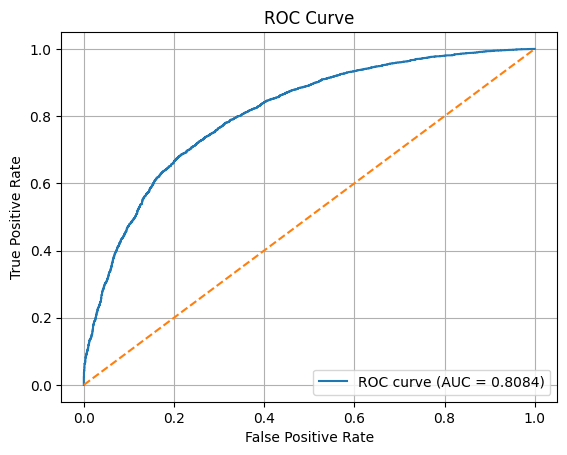

In [38]:
fpr, tpr, roc_thresholds = roc_curve(true_labels, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')  # random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

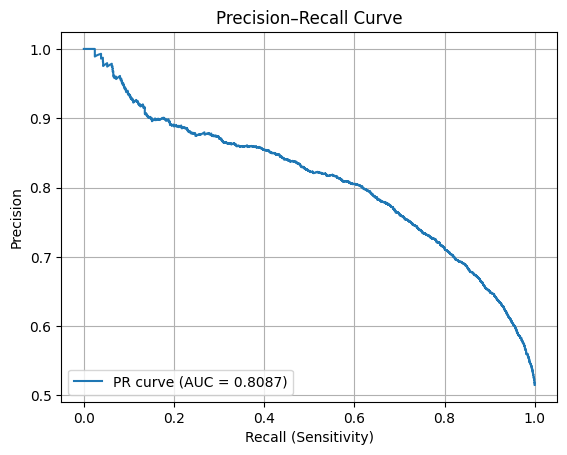

In [39]:
precision, recall, pr_thresholds = precision_recall_curve(true_labels, probabilities)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [67]:
cm = confusion_matrix(true_labels, predictions)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

In [68]:
print(f"Accuracy    : {accuracy_score(true_labels, predictions):.4f}")
print(f"Precision   : {precision_score(true_labels, predictions):.4f}")
print(f"Recall      : {recall_score(true_labels, predictions):.4f}")
print(f"Specificity : {specificity:.4f}")
print(f"F1 Score    : {f1_score(true_labels, predictions):.4f}")

Accuracy    : 0.7323
Precision   : 0.7202
Recall      : 0.7856
Specificity : 0.6757
F1 Score    : 0.7515


In [69]:
cm

array([[2346, 1126],
       [ 791, 2899]])

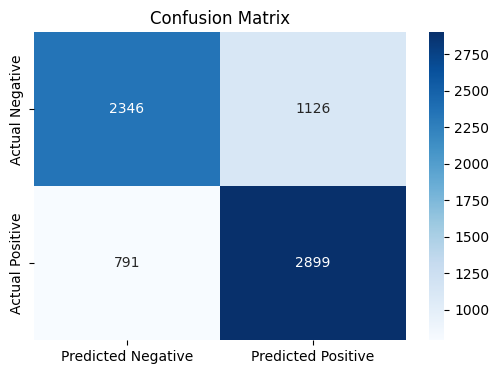

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrix
cm = np.array([[tn, fp],
               [fn, tp]])

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title("Confusion Matrix")
plt.show()